<a href="https://colab.research.google.com/github/geethudugamakorala/Opencv/blob/main/Valosens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Pointnet - Classification

In [ ]:
!pip install trimesh

In [ ]:
import os
import glob
import trimesh  # used to visualize .off meshfiles
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0005.off"))
mesh.show()

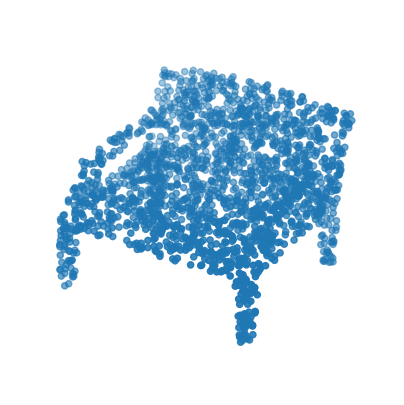

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
%cd ..

/


In [ ]:
!ls

bathtub  chair	dresser  night_stand  sofa   toilet
bed	 desk	monitor  README.txt   table


In [ ]:
f = open("/root/.keras/datasets/ModelNet10/README.txt", "r")

In [ ]:
f.read()

'This folder contains 10 categories of CAD models from the Princeton ModelNet dataset. \nThis 10 categories are used in our paper for experiments.\n\nFile format:\n\n1. The CAD models are saved as OFF file format [refer to http://segeval.cs.princeton.edu/public/off_format.html ]. \n2. You can open it in Meshlab http://meshlab.sourceforge.net\n3. You can use the following function in Matlab to load the models:\nhttp://vision.princeton.edu/pvt/RenderMe/RenderDepth/offLoader.m\n\nCitation:\n\nPlease cite the following document if you use this dataset:\nZ. Wu, S. Song, A. Khosla, X. Tang, and J. Xiao\n3D ShapeNets for 2.5D Object Recognition and Next-Best-View Prediction\narXiv:1406.5670 [cs.CV]\n\nQuestion or Bug?\n\nPlease contact with Jianxiong Xiao (xj [at] princeton [dot] edu)'

In [ ]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: table
processing class: sofa
processing class: toilet
processing class: night_stand
processing class: chair
processing class: dresser
processing class: monitor
processing class: desk
processing class: bathtub
processing class: bed


In [ ]:
DATA_DIR

'/root/.keras/datasets/ModelNet10'

In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters,
    kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model2 = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model2.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 2048, 32)     128         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 2048, 32)    128         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 2048, 32)     0           ['batch_normalization_17[0

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 46s 161ms/step - loss: 3.4809 - sparse_categorical_accuracy: 0.2899 - val_loss: 2900154341590153822208.0000 - val_sparse_categorical_accuracy: 0.2599
Epoch 2/20
125/125 [==============================] - 19s 155ms/step - loss: 3.0008 - sparse_categorical_accuracy: 0.3831 - val_loss: 126639474125002927767552.0000 - val_sparse_categorical_accuracy: 0.3095
Epoch 3/20
125/125 [==============================] - 19s 152ms/step - loss: 2.7472 - sparse_categorical_accuracy: 0.4891 - val_loss: 617104927621120.0000 - val_sparse_categorical_accuracy: 0.5242
Epoch 4/20
125/125 [==============================] - 19s 156ms/step - loss: 2.4622 - sparse_categorical_accuracy: 0.5770 - val_loss: 81960349204480.0000 - val_sparse_categorical_accuracy: 0.4989
Epoch 5/20
125/125 [==============================] - 20s 161ms/step - loss: 2.3174 - sparse_categorical_accuracy: 0.6274 - val_loss: 6634126848.0000 - val_sparse_categorical_accuracy: 0.5264
Epoch

1/1 [==============================] - 2s 2s/step


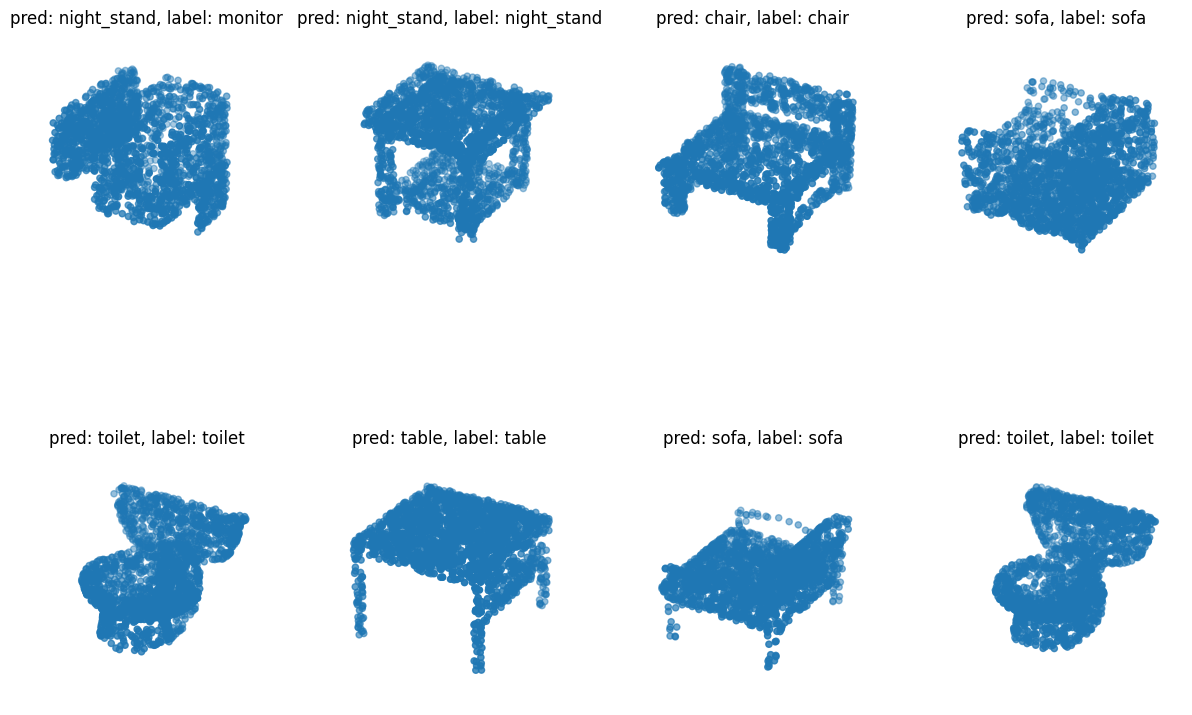

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model2.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
model

In [ ]:
model.save_weights('/content/drive/MyDrive/PointCloud/pointnet.h5')

#Poinet Classfication - inference

In [ ]:
#https://drive.google.com/drive/folders/1X0d_uo9_0Ni6u8qcvAghqmOC_vpqsAb1?usp=sharing
#Drive kink for model

In [ ]:
!pip install trimesh

In [ ]:
import os
import glob
import trimesh  # used to visualize .off meshfiles
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0005.off"))
mesh.show()

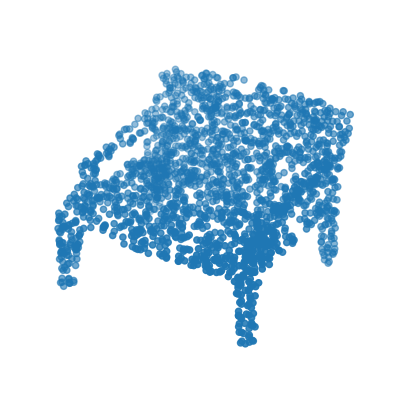

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [2]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [3]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

NameError: ignored

In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters,
    kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model2.summary()

In [ ]:
savedModel = model.load_weights('/content/drive/MyDrive/PointCloud/pointnet.h5')

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model2.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

##Pointnet -  Part Segmentation

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [ ]:
!wget "ftp://cs.stanford.edu/cs/cvgl/PASCAL3D+_release1.0.zip"

--2023-08-25 05:53:26--  ftp://cs.stanford.edu/cs/cvgl/PASCAL3D+_release1.0.zip
           => ‘PASCAL3D+_release1.0.zip’
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /cs/cvgl ... done.
==> SIZE PASCAL3D+_release1.0.zip ... 1028017875
==> PASV ... done.    ==> RETR PASCAL3D+_release1.0.zip ... done.
Length: 1028017875 (980M) (unauthoritative)

PASCAL3D+_release1. 100%[===================>] 980.39M  16.2MB/s    in 60s     

2023-08-25 05:54:28 (16.3 MB/s) - ‘PASCAL3D+_release1.0.zip’ saved [1028017875]



In [ ]:
!pwd

/content


In [ ]:
!unzip /content/PASCAL3D+_release1.0.zip

In [ ]:
dataset_url = "http://cvgl.stanford.edu/projects/pascal3d.html"

dataset_path = keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

In [ ]:
# dataset_url = "https://git.io/JiY4i"
dataset_url = "ftp://cs.stanford.edu/cs/cvgl/PASCAL3D+_release1.1.zip"

dataset_path = keras.utils.get_file(
    fname="PASCAL3D+.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

7483608797/7483608797 [==============================] - 132s 0us/step


In [ ]:
!cd /tmp/.keras/datasets
!pwd

/content


In [ ]:
!ls

PASCAL3D+_release1.0  PASCAL3D+_release1.0.zip	sample_data


In [ ]:
dataset_path

'/tmp/.keras/datasets/shapenet.zip'

In [ ]:
with open("/tmp/.keras/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

FileNotFoundError: ignored

In [ ]:
!ls "/tmp/.keras/"

datasets


In [ ]:
!ls "/tmp/.keras/datasets"

PASCAL3D+_release1.0  PASCAL3D+_release1.1  PASCAL3D+.zip  shapenet.zip


In [ ]:
!unzip /content/Stanford3dDataset_v1.2_Aligned_Version.zip

In [ ]:
!unzip /tmp/.keras/datasets/PASCAL3D+_release1.0

unzip:  cannot find or open /tmp/.keras/datasets/PASCAL3D+_release1.0, /tmp/.keras/datasets/PASCAL3D+_release1.0.zip or /tmp/.keras/datasets/PASCAL3D+_release1.0.ZIP.


In [ ]:
cd /tmp/.keras/datasets/PASCAL3D+_release1.0

/tmp/.keras/datasets/PASCAL3D+_release1.0


In [ ]:
ls /tmp/.keras/datasets/PASCAL3D+_release1.0

Annotations/  Annotation_tool/  CAD/  Images/  LICENSE  README


In [ ]:
!wget http://shapenet.cs.stanford.edu/shapenet/obj-zip/ShapeNetCore.v1.zip


--2023-08-24 05:08:56--  http://shapenet.cs.stanford.edu/shapenet/obj-zip/ShapeNetCore.v1.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:80... failed: Connection timed out.
Retrying.

--2023-08-24 05:11:06--  (try: 2)  http://shapenet.cs.stanford.edu/shapenet/obj-zip/ShapeNetCore.v1.zip
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:80... ^C



#Stanford 3D Indoor Scene Dataset (S3DIS)

In [ ]:
!pip install open3d==0.16.0 # must be at least 0.16.0

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from IPython.display import clear_output
import numpy as np
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
# from open3d.web_visualizer import draw # for non Colab

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://cvg-data.inf.ethz.ch/s3dis/Stanford3dDataset_v1.2.zip

--2023-08-29 03:19:35--  https://cvg-data.inf.ethz.ch/s3dis/Stanford3dDataset_v1.2.zip
Resolving cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)... 129.132.114.72
Connecting to cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)|129.132.114.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5149528258 (4.8G) [application/zip]
Saving to: ‘Stanford3dDataset_v1.2.zip’

Stanford3dDataset_v 100%[===================>]   4.79G  5.56MB/s    in 5m 5s   

2023-08-29 03:24:41 (16.1 MB/s) - ‘Stanford3dDataset_v1.2.zip’ saved [5149528258/5149528258]



In [ ]:
!unzip /content/Stanford3dDataset_v1.2.zip


  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/chair_134.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/chair_274.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/chair_210.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/clutter_15.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/chair_1.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/bookcase_2.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/chair_185.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/wall_22.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/chair_141.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/chair_53.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/chair_254.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/auditorium_2/Annotations/chair_205.

In [ ]:
!ls /tmp/.keras/datasets/PASCAL3D+_release1.0

Annotations	 CAD	 LICENSE  Stanford3dDataset_v1.2.zip
Annotation_tool  Images  README   temp


In [ ]:
mv Stanford3dDataset_v1.2.zip /content/Standford

mv: cannot stat 'Stanford3dDataset_v1.2.zip': No such file or directory


In [ ]:
!mv Stanford3dDataset_v1.2 /content/Standford

In [ ]:
!unzip -o /content/Stanford3dDataset_v1.2.zip

Streaming output truncated to the last 5000 lines.
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_6/Annotations/wall_3.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_6/Annotations/wall_4.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_6/Annotations/clutter_2.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_6/Annotations/door_1.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_6/Annotations/wall_5.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_6/hallway_6.txt  
   creating: Stanford3dDataset_v1.2/Area_2/hallway_5/
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_5/hallway_5.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_5/.DS_Store  
   creating: Stanford3dDataset_v1.2/Area_2/hallway_5/Annotations/
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_5/Annotations/clutter_16.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_5/Annotations/door_3.txt  
  inflating: Stanford3dDataset_v1.2/Area_2/hallway_5/Annotations/sofa_1.t

In [ ]:
s3dis_test = S3DIS(root='temp', test_area=6, train=False)

# split into valid and test sets
s3dis_valid = s3dis_test[:2000]
s3dis_test = s3dis_test[2000:]

In [ ]:
print(f'Number of train samples: {len(s3dis_train)}')
print(f'Number of validation samples: {len(s3dis_valid)}')
print(f'Number of test samples: {len(s3dis_test)}')
s3dis_train[0]

In [ ]:
s3dis_train[0].x.max(axis=0)

In [ ]:
s3dis_train[0].pos

In [ ]:
np.unique(s3dis_train[332].y)

In [ ]:
color_map = {
    0  : (255, 0, 0),
    1  : (0, 255, 0),
    2  : (0, 0, 255),
    3  : (255, 0, 255),
    4  : (0, 255, 255),
    5  : (255, 255, 0),
    6  : (128, 0, 128),
    7  : (128, 128, 0),
    8  : (0, 128, 128),
    9  : (128, 0, 255),
    10 : (255, 128, 0),
    11 : (0, 128, 255),
    12 : (128, 255, 128)
}

map_colors = lambda x : color_map[x]
v_map_colors = np.vectorize(map_colors)

In [ ]:
IDX = 3220

In [ ]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(s3dis_train[IDX].x[:, 3:].numpy())
# pcd.points = o3.utility.Vector3dVector(s3dis_train[IDX].pos.numpy())

pcd.colors = o3.utility.Vector3dVector(s3dis_train[IDX].x[:, :3].numpy())
# colors = np.vstack(v_map_colors(s3dis_train[IDX].y)).T
# pcd.colors = o3.utility.Vector3dVector(colors)

o3.visualization.draw_plotly([pcd])

In [ ]:
!wget https://shapenet.cs.stanford.edu/media/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip

--2023-08-24 06:11:17--  https://shapenet.cs.stanford.edu/media/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... ^C


In [ ]:
!wget http://buildingparser.stanford.edu/dataset.html

--2023-08-24 06:12:06--  http://buildingparser.stanford.edu/dataset.html
Resolving buildingparser.stanford.edu (buildingparser.stanford.edu)... 171.64.68.41
Connecting to buildingparser.stanford.edu (buildingparser.stanford.edu)|171.64.68.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35734 (35K) [text/html]
Saving to: ‘dataset.html’

dataset.html        100%[===================>]  34.90K  --.-KB/s    in 0.02s   

2023-08-24 06:12:07 (2.06 MB/s) - ‘dataset.html’ saved [35734/35734]



In [ ]:
%cd /content/Standford

/content/Standford


In [ ]:
import os
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.j_visualizer import JVisualizer
# from open3d.web_visualizer import draw # for non Colab

import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: ignored

#Pointnet part segmentation

In [ ]:
!wget https://huggingface.co/datasets/ShapeNet/ShapeNetCore-archive/blob/main/ShapeNetCore.v1.zip

--2023-08-29 03:08:33--  https://huggingface.co/datasets/ShapeNet/ShapeNetCore-archive/blob/main/ShapeNetCore.v1.zip
Resolving huggingface.co (huggingface.co)... 18.154.227.87, 18.154.227.67, 18.154.227.69, ...
Connecting to huggingface.co (huggingface.co)|18.154.227.87|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized

Username/Password Authentication Failed.


#Pointnet

In [ ]:
!pwd

/content/Standford


In [ ]:
!git clone https://github.com/fxia22/pointnet.pytorch

Cloning into 'pointnet.pytorch'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 213 (delta 0), reused 2 (delta 0), pack-reused 211
Receiving objects: 100% (213/213), 229.91 KiB | 722.00 KiB/s, done.
Resolving deltas: 100% (125/125), done.


In [ ]:
%cd pointnet.pytorch

[Errno 2] No such file or directory: 'pointnet.pytorch'
/content/Standford/pointnet.pytorch


In [ ]:
pip install -e .

Obtaining file:///content/Standford/pointnet.pytorch
  Preparing metadata (setup.py) ... done
  Running setup.py develop for pointnet


In [ ]:
!cd scripts
!bash build.sh #build C++ code for visualization
!bash download.sh #download dataset

bash: build.sh: No such file or directory
bash: download.sh: No such file or directory


In [ ]:
%cd scripts

/content/Standford/pointnet.pytorch/scripts


In [ ]:
%%shell
bash build.sh



/content/Standford/pointnet.pytorch/scripts


In [ ]:
!bash download.sh

--2023-08-24 06:19:07--  https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... failed: Connection timed out.
Retrying.

--2023-08-24 06:21:16--  (try: 2)  https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... failed: Connection timed out.
Retrying.

--2023-08-24 06:23:28--  (try: 3)  https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... ^C


In [ ]:
%cd utils

/content/Standford/pointnet.pytorch/utils


In [ ]:
!python train_segmentation.py --dataset /content/Standford/Stanford3dDataset_v1.2 --nepoch=2

Namespace(batchSize=32, workers=4, nepoch=2, outf='seg', model='', dataset='/content/Standford/Stanford3dDataset_v1.2', class_choice='Chair', feature_transform=False)
Random Seed:  1924
Traceback (most recent call last):
  File "/content/Standford/pointnet.pytorch/utils/train_segmentation.py", line 37, in <module>
    dataset = ShapeNetDataset(
  File "/content/Standford/pointnet.pytorch/pointnet/dataset.py", line 72, in __init__
    with open(self.catfile, 'r') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/content/Standford/Stanford3dDataset_v1.2/synsetoffset2category.txt'


In [ ]:
!wget https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_v0.zip

--2023-08-24 06:29:01--  https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_v0.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... failed: Connection timed out.
Retrying.

--2023-08-24 06:31:14--  (try: 2)  https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_v0.zip
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... ^C


#Pointnet Segmentation



In [1]:
print("hwllo world")

hwllo world


In [ ]:
!wget https://cvg-data.inf.ethz.ch/s3dis/Stanford3dDataset_v1.2_Aligned_Version.zip

--2023-08-29 04:41:39--  https://cvg-data.inf.ethz.ch/s3dis/Stanford3dDataset_v1.2_Aligned_Version.zip
Resolving cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)... 129.132.114.72
Connecting to cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)|129.132.114.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4394701719 (4.1G) [application/zip]
Saving to: ‘Stanford3dDataset_v1.2_Aligned_Version.zip’

Stanford3dDataset_v 100%[===================>]   4.09G  30.4MB/s    in 2m 20s  

2023-08-29 04:44:01 (29.9 MB/s) - ‘Stanford3dDataset_v1.2_Aligned_Version.zip’ saved [4394701719/4394701719]



In [ ]:
!unzip /content/Stanford3dDataset_v1.2_Aligned_Version.zip

In [ ]:
!wget https://shapenet.cs.stanford.edu/media/indoor3d_sem_seg_hdf5_data.zip

--2023-08-29 03:41:46--  https://shapenet.cs.stanford.edu/media/indoor3d_sem_seg_hdf5_data.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... ^C


In [ ]:
import os
import re
from glob import glob
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchmetrics
# from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.web_visualizer import draw # for non Colab

import matplotlib.pyplot as plt
%matplotlib inline

[Open3D INFO] Resetting default logger to print to terminal.


In [ ]:
# dataset
ROOT = r'/content/Stanford3dDataset_v1.2'

# feature selection hyperparameters
NUM_TRAIN_POINTS = 4096 # train/valid points
NUM_TEST_POINTS = 15000

BATCH_SIZE = 16

In [ ]:
CATEGORIES = {
    'ceiling'  : 0,
    'floor'    : 1,
    'wall'     : 2,
    'beam'     : 3,
    'column'   : 4,
    'window'   : 5,
    'door'     : 6,
    'table'    : 7,
    'chair'    : 8,
    'sofa'     : 9,
    'bookcase' : 10,
    'board'    : 11,
    'stairs'   : 12,
    'clutter'  : 13
}

# unique color map generated via
# https://mokole.com/palette.html
COLOR_MAP = {
    0  : (47, 79, 79),    # ceiling - darkslategray
    1  : (139, 69, 19),   # floor - saddlebrown
    2  : (34, 139, 34),   # wall - forestgreen
    3  : (75, 0, 130),    # beam - indigo
    4  : (255, 0, 0),     # column - red
    5  : (255, 255, 0),   # window - yellow
    6  : (0, 255, 0),     # door - lime
    7  : (0, 255, 255),   # table - aqua
    8  : (0, 0, 255),     # chair - blue
    9  : (255, 0, 255),   # sofa - fuchsia
    10 : (238, 232, 170), # bookcase - palegoldenrod
    11 : (100, 149, 237), # board - cornflower
    12 : (255, 105, 180), # stairs - hotpink
    13 : (0, 0, 0)        # clutter - black
}

v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

NUM_CLASSES = len(CATEGORIES)

In [ ]:
ROOT = r'/content/Stanford3dDataset_v1.2'
SAVE_PATH = r'/content/Datasets/file1'
PARTITION_SAVE_PATH = r'/content/Datasets/file2'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

if not os.path.exists(PARTITION_SAVE_PATH):
    os.mkdir(PARTITION_SAVE_PATH)

In [ ]:
area_nums = '1-6' # decide on the number of areas to obtain
area_dict = {}

# get areas based on split
areas = glob(os.path.join(ROOT, f'Area_[{area_nums}]*'))

for area in areas:
    # get all subfolders in area (corresponds to disjoint spaces (or locations))
    spaces = next(os.walk(area))[1]

    # get dict to store spaces
    space_dict = {}

    # for each space
    for space in spaces:
        space = os.path.join(area, space)
        annotations = os.path.join(space, 'Annotations')

        # get individual segmentation filepaths
        segments = glob(os.path.join(annotations, '*.txt'))

        # update space dict
        space_dict.update({space.split('/')[-1] : segments})

    # update area dict
    area_dict.update({area.split('/')[-1] : space_dict})

In [ ]:
area_dict.keys()

dict_keys(['/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_2', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_1', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_4', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_3', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_6'])

In [ ]:
def get_space_data(space_segments, categories=CATEGORIES):
    ''' Obtains space data in (x,y,z),cat format all types are float32
        Inputs:
            space_segments - (list) filepaths to all annotaed space segments
                            for the current space.
                            e.g. area_dict['Area_1']['conferenceRoom_2']
            categories - (dict) maps string category to numeric category
        Outputs:
            space_data - (array)
        '''
    # space data list (x,y,z, cat)
    # print(CATEGORIES)
    # print(space_segments)
    space_data = []
    for seg_path in space_segments:

        # get truth category and xyz points
        cat = CATEGORIES[seg_path.split('/')[-1].split('_')[0]]
        xyz = pd.read_csv(seg_path, header=None, sep=' ',
                          dtype=np.float32, usecols=[0,1,2]).to_numpy()

        # add truth to xyz points and add to space list
        space_data.append(np.hstack((xyz,
                                     np.tile(cat, (len(xyz), 1)) \
                                     .astype(np.float32))))

    # combine into single array and return
    return np.vstack(space_data)
# get_space_data(area_dict[area][space])

In [ ]:
tic = time.time()

for area in area_dict:
    # create new directory
    save_dir = os.path.join(SAVE_PATH, area)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    for space in area_dict[area]:
        # obtain xyz points with truth labels
        space_data = pd.DataFrame(get_space_data(area_dict[area][space]))

        # save as .hdf5 file in new directory
        save_path = os.path.join(save_dir, space + '.hdf5')
        space_data.to_hdf(save_path, key='space_data')


toc = time.time()
print(toc - tic)

736.737494468689


In [ ]:
ROOT

'/content/Stanford3dDataset_v1.2'

In [ ]:
from torch.utils.data import DataLoader
s3dis_train = S3DIS("/content/Datasets/file1", area_nums='1-4', npoints=NUM_TRAIN_POINTS, r_prob=0.25)
s3dis_valid = S3DIS("/content/Datasets/file1", area_nums='5', npoints=NUM_TRAIN_POINTS, r_prob=0.)
s3dis_test = S3DIS("/content/Datasets/file1", area_nums='6', split='test', npoints=NUM_TEST_POINTS)


['/content/Datasets/file1/Area_2/conferenceRoom_1.hdf5', '/content/Datasets/file1/Area_2/storage_9.hdf5', '/content/Datasets/file1/Area_2/office_10.hdf5', '/content/Datasets/file1/Area_2/office_4.hdf5', '/content/Datasets/file1/Area_2/hallway_8.hdf5', '/content/Datasets/file1/Area_2/storage_2.hdf5', '/content/Datasets/file1/Area_2/hallway_1.hdf5', '/content/Datasets/file1/Area_2/WC_1.hdf5', '/content/Datasets/file1/Area_2/office_12.hdf5', '/content/Datasets/file1/Area_2/hallway_3.hdf5', '/content/Datasets/file1/Area_2/hallway_7.hdf5', '/content/Datasets/file1/Area_2/storage_4.hdf5', '/content/Datasets/file1/Area_2/office_14.hdf5', '/content/Datasets/file1/Area_2/storage_8.hdf5', '/content/Datasets/file1/Area_2/office_3.hdf5', '/content/Datasets/file1/Area_2/hallway_12.hdf5', '/content/Datasets/file1/Area_2/WC_2.hdf5', '/content/Datasets/file1/Area_2/office_9.hdf5', '/content/Datasets/file1/Area_2/storage_3.hdf5', '/content/Datasets/file1/Area_2/hallway_2.hdf5', '/content/Datasets/file1

In [ ]:
s3dis_train

In [ ]:
train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(s3dis_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(s3dis_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
len(train_dataloader)

10

In [ ]:
points, targets = s3dis_test[6]

In [ ]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets)).T/255)


In [ ]:
o3.visualization.draw_plotly([pcd])

In [ ]:
space_data = get_space_data(area_dict['Area_1']['conferenceRoom_1'], categories=CATEGORIES)


In [ ]:
space_data

array([[-15.383,  40.042,   0.529,   8.   ],
       [-15.378,  40.057,   0.535,   8.   ],
       [-15.386,  40.032,   0.527,   8.   ],
       ...,
       [-19.224,  36.863,   0.848,  11.   ],
       [-19.229,  36.861,   0.848,  11.   ],
       [-19.233,  36.851,   0.857,  11.   ]], dtype=float32)

In [ ]:
''' Dataset for The aligned, reduced, partitioned S3DIS dataset
    Provides functionality for train/test on partitioned sets as well
    as testing on entire spaces via get_random_partitioned_space()
    '''

import os
from glob import glob
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset


class S3DIS(Dataset):
    def __init__(self, root, area_nums, split='train', npoints=4096, r_prob=0.25):
        self.root = root
        self.area_nums = area_nums # i.e. '1-4' # areas 1-4
        self.split = split.lower() # use 'test' in order to bypass augmentations
        self.npoints = npoints     # use  None to sample all the points
        self.r_prob = r_prob       # probability of rotation

        # glob all hdf paths
        areas = glob(os.path.join(root, f'Area_[{area_nums}]*'))
        # print(areas)
        # get all datapaths
        self.data_paths = []
        for area in areas:
          # print(area)
          # print("glob " ,glob(os.path.join(area, '**/*.hdf5'), recursive=True))
          self.data_paths += glob(os.path.join(area, '**/*.hdf5'),
                                    recursive=True)
        # print(self.data_paths)

        # get unique space identifiers (area_##\\spacename_##_)
        self.space_ids = []
        for fp in self.data_paths:
            area, space = fp.split('/')[-2:]
            space_id = '/'.join([area, '_'.join(space.split('_')[:2])]) + '_'
            self.space_ids.append(space_id)

        self.space_ids = list(set(self.space_ids))
        print(self.data_paths, self.space_ids)


    def __getitem__(self, idx):
        # read data from hdf5
        space_data = pd.read_hdf(self.data_paths[idx]).to_numpy()
        points = space_data[:, :3] # xyz points
        targets = space_data[:, 3]    # integer categories

        # down sample point cloud
        if self.npoints:
            points, targets = self.downsample(points, targets)

        # add Gaussian noise to point set if not testing
        if self.split != 'test':
            # add N(0, 1/100) noise
            points += np.random.normal(0., 0.01, points.shape)

            # add random rotation to the point cloud with probability
            if np.random.uniform(0, 1) > 1 - self.r_prob:
                points = self.random_rotate(points)


        # Normalize Point Cloud to (0, 1)
        points = self.normalize_points(points)

        # convert to torch
        points = torch.from_numpy(points).type(torch.float32)
        targets = torch.from_numpy(targets).type(torch.LongTensor)

        return points, targets


    def get_random_partitioned_space(self):
        ''' Obtains a Random space. In this case the batchsize would be
            the number of partitons that the space was separated into.
            This is a special function for testing.
            '''

        # get random space id
        idx = random.randint(0, len(self.space_ids) - 1)
        space_id = self.space_ids[idx]

        # get all filepaths for randomly selected space
        space_paths = []
        for fpath in self.data_paths:
            if space_id in fpath:
                space_paths.append(fpath)

        # assume npoints is very large if not passed
        if not self.npoints:
            self.npoints = 20000

        points = np.zeros((len(space_paths), self.npoints, 3))
        targets = np.zeros((len(space_paths), self.npoints))

        # obtain data
        for i, space_path in enumerate(space_paths):
            space_data = pd.read_hdf(space_path, key='space_slice').to_numpy()
            _points = space_data[:, :3] # xyz points
            _targets = space_data[:, 3] # integer categories

            # downsample point cloud
            _points, _targets = self.downsample(_points, _targets)

            # add points and targets to batch arrays
            points[i] = _points
            targets[i] = _targets

        # convert to torch
        points = torch.from_numpy(points).type(torch.float32)
        targets = torch.from_numpy(targets).type(torch.LongTensor)

        return points, targets


    def downsample(self, points, targets):
        if len(points) > self.npoints:
            choice = np.random.choice(len(points), self.npoints, replace=False)
        else:
            # case when there are less points than the desired number
            choice = np.random.choice(len(points), self.npoints, replace=True)
        points = points[choice, :]
        targets = targets[choice]

        return points, targets


    @staticmethod
    def random_rotate(points):
        ''' randomly rotates point cloud about vertical axis.
            Code is commented out to rotate about all axes
            '''
        # construct a randomly parameterized 3x3 rotation matrix
        phi = np.random.uniform(-np.pi, np.pi)
        theta = np.random.uniform(-np.pi, np.pi)
        psi = np.random.uniform(-np.pi, np.pi)

        rot_x = np.array([
            [1,              0,                 0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi), np.cos(phi) ]])

        rot_y = np.array([
            [np.cos(theta),  0, np.sin(theta)],
            [0,                 1,                0],
            [-np.sin(theta), 0, np.cos(theta)]])

        rot_z = np.array([
            [np.cos(psi), -np.sin(psi), 0],
            [np.sin(psi), np.cos(psi),  0],
            [0,              0,                 1]])

        # rot = np.matmul(rot_x, np.matmul(rot_y, rot_z))

        return np.matmul(points, rot_z)


    @staticmethod
    def normalize_points(points):
        ''' Perform min/max normalization on points
            Same as:
            (x - min(x))/(max(x) - min(x))
            '''
        points = points - points.min(axis=0)
        points /= points.max(axis=0)

        return points


    def __len__(self):
        return len(self.data_paths)

In [ ]:
from torch.utils.data import DataLoader
s3dis_train = S3DIS("/content/Datasets/file1", area_nums='1-4', npoints=NUM_TRAIN_POINTS, r_prob=0.25)
train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)

['/content/Datasets/file1/Area_2/conferenceRoom_1.hdf5', '/content/Datasets/file1/Area_2/storage_9.hdf5', '/content/Datasets/file1/Area_2/office_10.hdf5', '/content/Datasets/file1/Area_2/office_4.hdf5', '/content/Datasets/file1/Area_2/hallway_8.hdf5', '/content/Datasets/file1/Area_2/storage_2.hdf5', '/content/Datasets/file1/Area_2/hallway_1.hdf5', '/content/Datasets/file1/Area_2/WC_1.hdf5', '/content/Datasets/file1/Area_2/office_12.hdf5', '/content/Datasets/file1/Area_2/hallway_3.hdf5', '/content/Datasets/file1/Area_2/hallway_7.hdf5', '/content/Datasets/file1/Area_2/storage_4.hdf5', '/content/Datasets/file1/Area_2/office_14.hdf5', '/content/Datasets/file1/Area_2/storage_8.hdf5', '/content/Datasets/file1/Area_2/office_3.hdf5', '/content/Datasets/file1/Area_2/hallway_12.hdf5', '/content/Datasets/file1/Area_2/WC_2.hdf5', '/content/Datasets/file1/Area_2/office_9.hdf5', '/content/Datasets/file1/Area_2/storage_3.hdf5', '/content/Datasets/file1/Area_2/hallway_2.hdf5', '/content/Datasets/file1

In [ ]:
s3dis_train = S3DIS("/content/Datasets/file1/", area_nums='1-4', npoints=NUM_TRAIN_POINTS, r_prob=0.25)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)

ValueError: ignored

In [ ]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(space_data[:,:3])

In [ ]:
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(space_data[:, 3])).T/255)

In [ ]:
total_train_targets = []
for (_, targets) in space_data[:, 3]:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

TypeError: ignored

In [ ]:
get_space_data(area_dict[area][space])

{'ceiling': 0, 'floor': 1, 'wall': 2, 'beam': 3, 'column': 4, 'window': 5, 'door': 6, 'table': 7, 'chair': 8, 'sofa': 9, 'bookcase': 10, 'board': 11, 'stairs': 12, 'clutter': 13}
['/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/wall_2.txt', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/board_1.txt', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/clutter_1.txt', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/ceiling_1.txt', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/clutter_3.txt', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/clutter_7.txt', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/chair_1.txt', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/chair_2.txt', '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations

array([[-2.5814e+01, -1.1995e+01,  1.1000e-02,  2.0000e+00],
       [-2.5814e+01, -1.1971e+01,  2.7000e-02,  2.0000e+00],
       [-2.5816e+01, -1.1995e+01,  2.0000e-02,  2.0000e+00],
       ...,
       [-2.1571e+01, -1.0390e+01,  1.0950e+00,  2.0000e+00],
       [-2.1572e+01, -1.0399e+01,  1.0940e+00,  2.0000e+00],
       [-2.1572e+01, -1.0356e+01,  1.1140e+00,  2.0000e+00]],
      dtype=float32)

In [ ]:
area_dict[area][space]

['/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/wall_2.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/board_1.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/clutter_1.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/ceiling_1.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/clutter_3.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/clutter_7.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/chair_1.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/chair_2.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/clutter_5.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30/Annotations/clutter_6.txt',
 '/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/of

In [ ]:
area

'/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5'

In [ ]:
space

'/content/Stanford3dDataset_v1.2_Aligned_Version/Area_5/office_30'

In [ ]:
tic = time.time()

for area in area_dict:
    # create new directory
    save_dir = os.path.join(SAVE_PATH, area)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    for space in area_dict[area]:
        # obtain xyz points with truth labels
        # print(space)
        space_data = pd.DataFrame(get_space_data(area_dict[area][space]))
        # print(space_data)
        # save as .hdf5 file in new directory
        save_path = os.path.join(save_dir, space + '.hdf5')
        space_data.to_hdf(save_path, key='space_data')


toc = time.time()
print(toc - tic)

376.12763500213623


In [ ]:
get_space_data(area_dict[area][space])

In [ ]:
area

'/content/Stanford3dDataset_v1.2_Aligned_Version/Area_6'

In [ ]:
space

'/content/Stanford3dDataset_v1.2_Aligned_Version/Area_6/office_28'

In [ ]:
space_data = get_space_data(area_dict[area][space], categories=CATEGORIES)

In [ ]:
space_data

In [ ]:
''' Dataset for The aligned, reduced, partitioned S3DIS dataset
    Provides functionality for train/test on partitioned sets as well
    as testing on entire spaces via get_random_partitioned_space()
    '''

import os
from glob import glob
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset


class S3DIS(Dataset):
    def __init__(self, root, area_nums, split='train', npoints=4096, r_prob=0.25):
        self.root = root
        self.area_nums = area_nums # i.e. '1-4' # areas 1-4
        self.split = split.lower() # use 'test' in order to bypass augmentations
        self.npoints = npoints     # use  None to sample all the points
        self.r_prob = r_prob       # probability of rotation

        # glob all hdf paths
        areas = glob(os.path.join(root, f'Area_[{area_nums}]*'))

        # get all datapaths
        self.data_paths = []
        for area in areas:
            self.data_paths += glob(os.path.join(area, '**\*.hdf5'),
                                    recursive=True)

        # get unique space identifiers (area_##\\spacename_##_)
        self.space_ids = []
        for fp in self.data_paths:
            area, space = fp.split('\\')[-2:]
            space_id = '\\'.join([area, '_'.join(space.split('_')[:2])]) + '_'
            self.space_ids.append(space_id)

        self.space_ids = list(set(self.space_ids))


    def __getitem__(self, idx):
        # read data from hdf5
        space_data = pd.read_hdf(self.data_paths[idx], key='space_slice').to_numpy()
        points = space_data[:, :3] # xyz points
        targets = space_data[:, 3]    # integer categories

        # down sample point cloud
        if self.npoints:
            points, targets = self.downsample(points, targets)

        # add Gaussian noise to point set if not testing
        if self.split != 'test':
            # add N(0, 1/100) noise
            points += np.random.normal(0., 0.01, points.shape)

            # add random rotation to the point cloud with probability
            if np.random.uniform(0, 1) > 1 - self.r_prob:
                points = self.random_rotate(points)


        # Normalize Point Cloud to (0, 1)
        points = self.normalize_points(points)

        # convert to torch
        points = torch.from_numpy(points).type(torch.float32)
        targets = torch.from_numpy(targets).type(torch.LongTensor)

        return points, targets


    def get_random_partitioned_space(self):
        ''' Obtains a Random space. In this case the batchsize would be
            the number of partitons that the space was separated into.
            This is a special function for testing.
            '''

        # get random space id
        idx = random.randint(0, len(self.space_ids) - 1)
        space_id = self.space_ids[idx]

        # get all filepaths for randomly selected space
        space_paths = []
        for fpath in self.data_paths:
            if space_id in fpath:
                space_paths.append(fpath)

        # assume npoints is very large if not passed
        if not self.npoints:
            self.npoints = 20000

        points = np.zeros((len(space_paths), self.npoints, 3))
        targets = np.zeros((len(space_paths), self.npoints))

        # obtain data
        for i, space_path in enumerate(space_paths):
            space_data = pd.read_hdf(space_path, key='space_slice').to_numpy()
            _points = space_data[:, :3] # xyz points
            _targets = space_data[:, 3] # integer categories

            # downsample point cloud
            _points, _targets = self.downsample(_points, _targets)

            # add points and targets to batch arrays
            points[i] = _points
            targets[i] = _targets

        # convert to torch
        points = torch.from_numpy(points).type(torch.float32)
        targets = torch.from_numpy(targets).type(torch.LongTensor)

        return points, targets


    def downsample(self, points, targets):
        if len(points) > self.npoints:
            choice = np.random.choice(len(points), self.npoints, replace=False)
        else:
            # case when there are less points than the desired number
            choice = np.random.choice(len(points), self.npoints, replace=True)
        points = points[choice, :]
        targets = targets[choice]

        return points, targets


    @staticmethod
    def random_rotate(points):
        ''' randomly rotates point cloud about vertical axis.
            Code is commented out to rotate about all axes
            '''
        # construct a randomly parameterized 3x3 rotation matrix
        phi = np.random.uniform(-np.pi, np.pi)
        theta = np.random.uniform(-np.pi, np.pi)
        psi = np.random.uniform(-np.pi, np.pi)

        rot_x = np.array([
            [1,              0,                 0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi), np.cos(phi) ]])

        rot_y = np.array([
            [np.cos(theta),  0, np.sin(theta)],
            [0,                 1,                0],
            [-np.sin(theta), 0, np.cos(theta)]])

        rot_z = np.array([
            [np.cos(psi), -np.sin(psi), 0],
            [np.sin(psi), np.cos(psi),  0],
            [0,              0,                 1]])

        # rot = np.matmul(rot_x, np.matmul(rot_y, rot_z))

        return np.matmul(points, rot_z)


    @staticmethod
    def normalize_points(points):
        ''' Perform min/max normalization on points
            Same as:
            (x - min(x))/(max(x) - min(x))
            '''
        points = points - points.min(axis=0)
        points /= points.max(axis=0)

        return points


    def __len__(self):
        return len(self.data_paths)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
from torch.utils.data import DataLoader
# from s3dis_dataset import S3DIS

# get datasets
s3dis_train = S3DIS(ROOT, area_nums='1-4', npoints=NUM_TRAIN_POINTS, r_prob=0.25)
s3dis_valid = S3DIS(ROOT, area_nums='5', npoints=NUM_TRAIN_POINTS, r_prob=0.)
s3dis_test = S3DIS(ROOT, area_nums='6', split='test', npoints=NUM_TEST_POINTS)

# # get dataloaders
# train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)
# valid_dataloader = DataLoader(s3dis_valid, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(s3dis_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(s3dis_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(s3dis_test, batch_size=BATCH_SIZE, shuffle=False)

ValueError: ignored

In [ ]:
import torch_geometric
from torch_geometric.datasets import S3DIS

ModuleNotFoundError: ignored

#pointnet segg

In [ ]:
import os
import re
from glob import glob
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchmetrics
# from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.web_visualizer import draw # for non Colab

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
ROOT = r'/content/Stanford3dDataset_v1.2_Aligned_Version'

# feature selection hyperparameters
NUM_TRAIN_POINTS = 4096 # train/valid points
NUM_TEST_POINTS = 15000

BATCH_SIZE = 16

In [ ]:
CATEGORIES = {
    'ceiling'  : 0,
    'floor'    : 1,
    'wall'     : 2,
    'beam'     : 3,
    'column'   : 4,
    'window'   : 5,
    'door'     : 6,
    'table'    : 7,
    'chair'    : 8,
    'sofa'     : 9,
    'bookcase' : 10,
    'board'    : 11,
    'stairs'   : 12,
    'clutter'  : 13
}

# unique color map generated via
# https://mokole.com/palette.html
COLOR_MAP = {
    0  : (47, 79, 79),    # ceiling - darkslategray
    1  : (139, 69, 19),   # floor - saddlebrown
    2  : (34, 139, 34),   # wall - forestgreen
    3  : (75, 0, 130),    # beam - indigo
    4  : (255, 0, 0),     # column - red
    5  : (255, 255, 0),   # window - yellow
    6  : (0, 255, 0),     # door - lime
    7  : (0, 255, 255),   # table - aqua
    8  : (0, 0, 255),     # chair - blue
    9  : (255, 0, 255),   # sofa - fuchsia
    10 : (238, 232, 170), # bookcase - palegoldenrod
    11 : (100, 149, 237), # board - cornflower
    12 : (255, 105, 180), # stairs - hotpink
    13 : (0, 0, 0)        # clutter - black
}

v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

NUM_CLASSES = len(CATEGORIES)

In [ ]:
from torch.utils.data import DataLoader
#from s3dis_dataset import S3DIS

# get datasets
s3dis_train = S3DIS(ROOT, area_nums='1-4', npoints=NUM_TRAIN_POINTS, r_prob=0.25)
s3dis_valid = S3DIS(ROOT, area_nums='5', npoints=NUM_TRAIN_POINTS, r_prob=0.)
s3dis_test = S3DIS(ROOT, area_nums='6', split='test', npoints=NUM_TEST_POINTS)

# get dataloaders
train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(s3dis_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(s3dis_test, batch_size=BATCH_SIZE, shuffle=False)

[] []
[] []
[] []


ValueError: ignored